# SVMC implementation

In [1]:
from simpa import Tags
import simpa as sp
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from skimage import measure
from scipy.ndimage import gaussian_filter
plt.rcParams['figure.figsize'] = (8, 8)

In [2]:
# utility code for plotting intermediate states
def plot_voxels(voxels):
    labels = np.sort(np.unique(voxels))
    fig, axs = plt.subplots(ncols=len(labels), figsize=(20,10), subplot_kw={'projection':'3d'})
    for ax, label in zip(axs, labels):
        x, y, z = np.where(voxels == label)
        ax.set_title(f"Voxels: label {label}")
        ax.scatter(x, y, z, color='blue')
        ax.set_xlim(0,voxels.shape[0])
        ax.set_ylim(0,voxels.shape[1])
        ax.set_zlim(0,voxels.shape[2])
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        ax.set_zlabel('Z')
    plt.tight_layout()
    plt.show()

def plot_triangles(triangles, label, shape):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    mesh = Poly3DCollection(triangles)
    mesh.set_edgecolor('k')
    mesh.set_linewidth(0.1)
    ax.set_title(f"Triangular surface mesh, label {label}")
    ax.add_collection3d(mesh)
    ax.set_xlim(0,shape[0])
    ax.set_ylim(0,shape[1])
    ax.set_zlim(0,shape[2])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

def plot_normals(normals, centroids, label, shape):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.quiver(centroids[0], centroids[1], centroids[2], normals[0], normals[1], normals[2])
    ax.set_title(f"Normals, label {label}")
    ax.set_xlim(0,shape[0])
    ax.set_ylim(0,shape[1])
    ax.set_zlim(0,shape[2])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

def plot_centroids(centroids, label, shape):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(centroids[0], centroids[1], centroids[2], s=0.5)
    ax.set_title(f"Centroids, label {label}")
    ax.set_xlim(0,shape[0])
    ax.set_ylim(0,shape[1])
    ax.set_zlim(0,shape[2])
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

### Generate labelled voxel data

In [3]:
# generate volumes from this example: https://github.com/fangq/mcx/blob/master/mcxlab/examples/demo_svmc_sphshells.m
def generate_vol(dim=60):
    xi, yi, zi = np.ogrid[0.5:(dim+0.5),0.5:(dim+0.5),0.5:(dim+0.5)]
    mcxvol = np.zeros((dim,dim,dim), dtype=np.uint8)
    dist = np.power((xi - 30.5),2) + np.power((yi - 30.5),2) + np.power((zi - 30.5),2)
    mcxvol[dist < 625] = 1
    mcxvol[dist < 529] = 2
    mcxvol[dist < 100] = 3
    return mcxvol

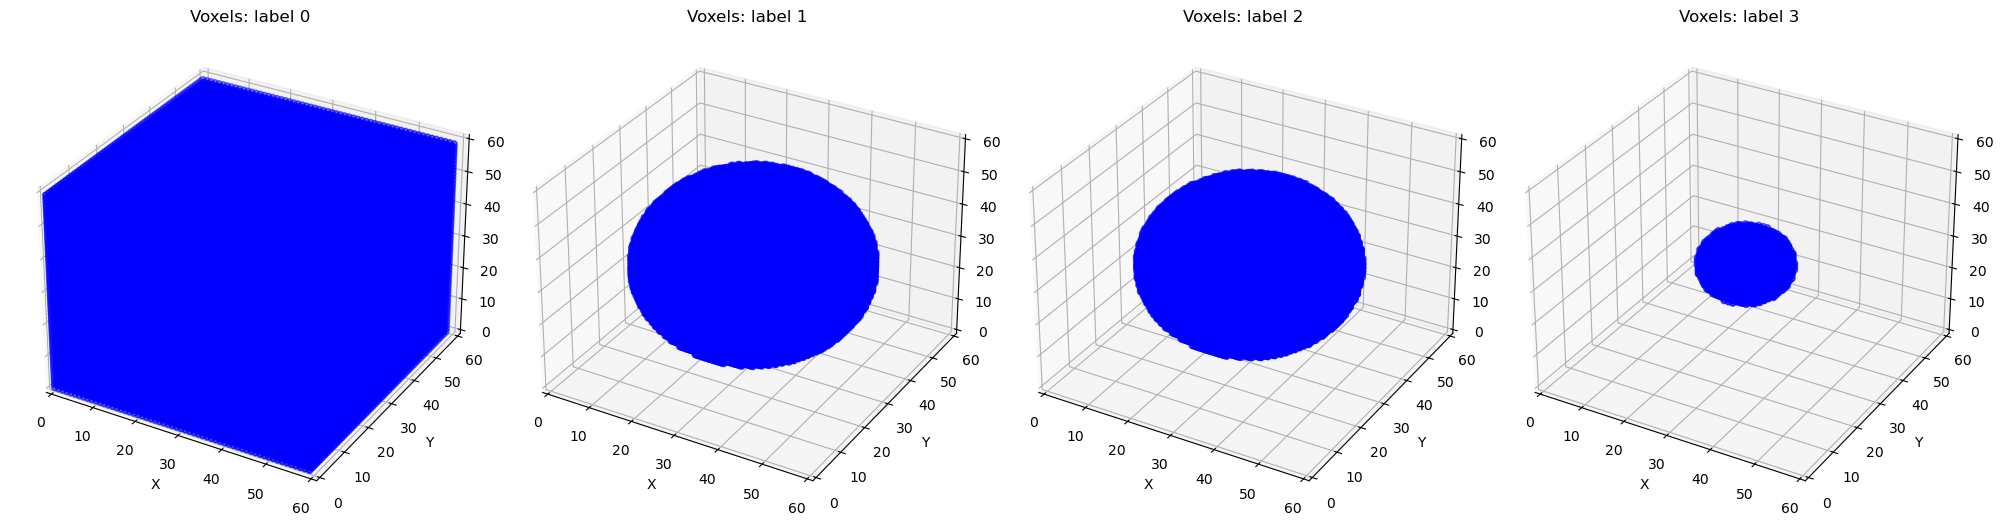

In [4]:
mcxvol = generate_vol()
plot_voxels(mcxvol)

### SVMC algorithm
- Implementation based on description in https://doi.org/10.1364/BOE.409468

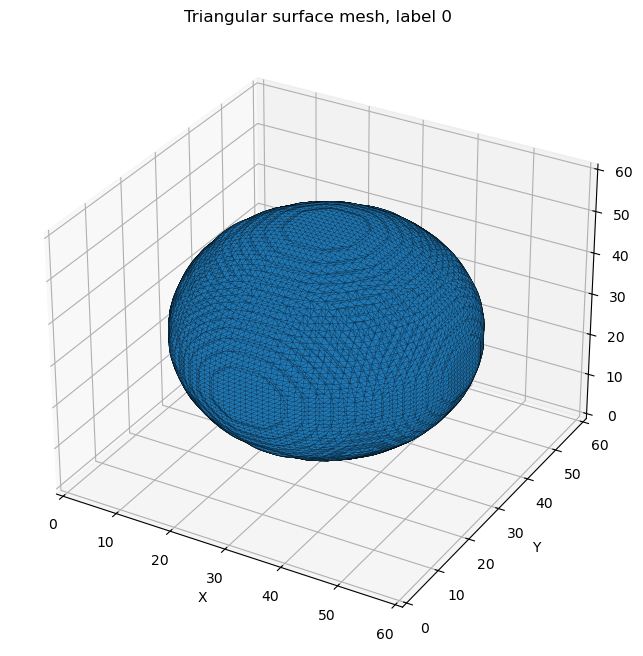

Excluded 6856/23288 triangles with area < 0.2


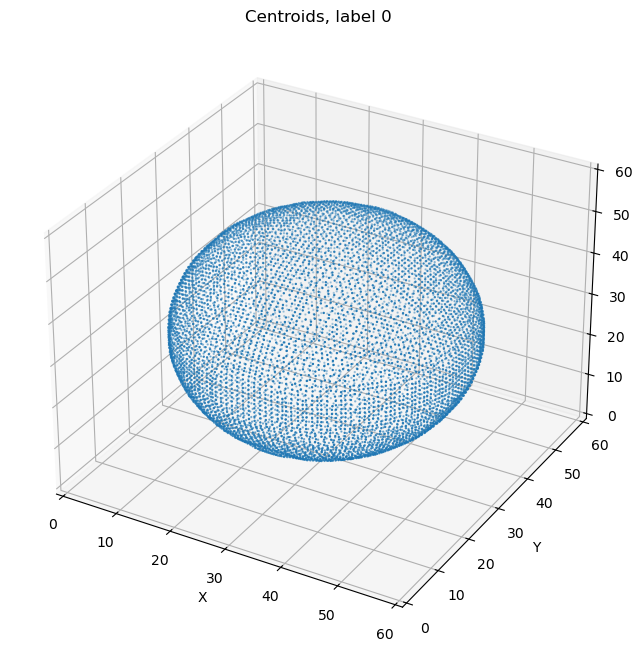

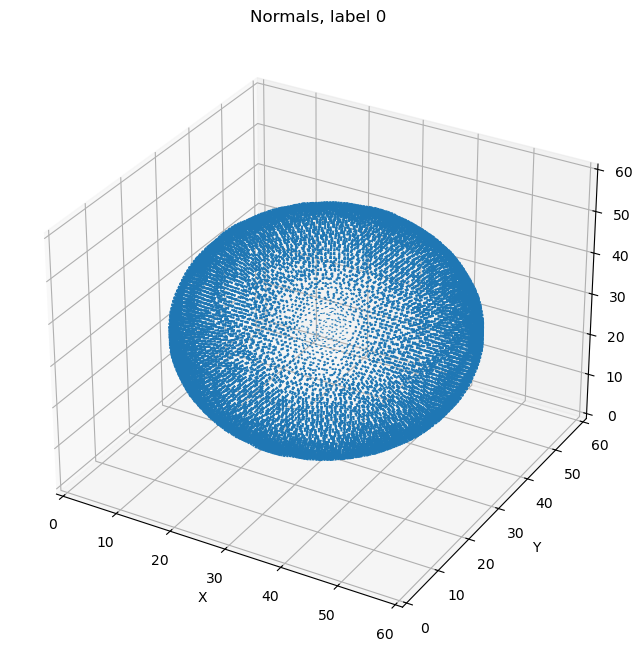

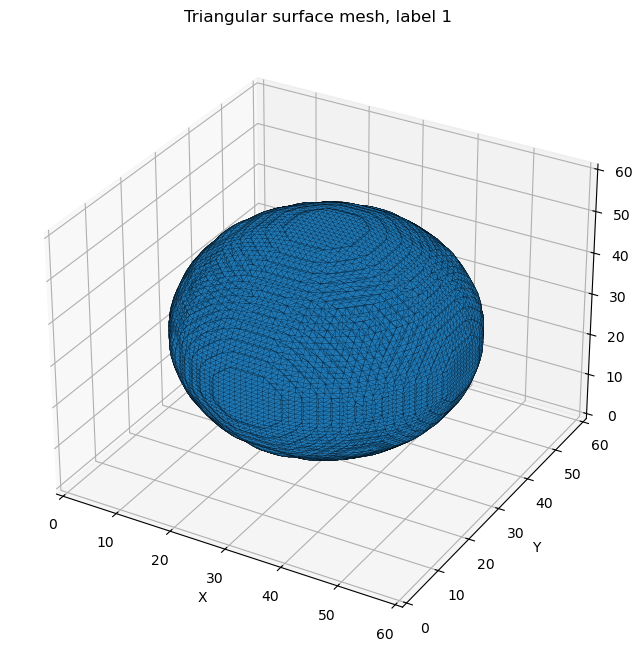

Excluded 13752/43072 triangles with area < 0.2


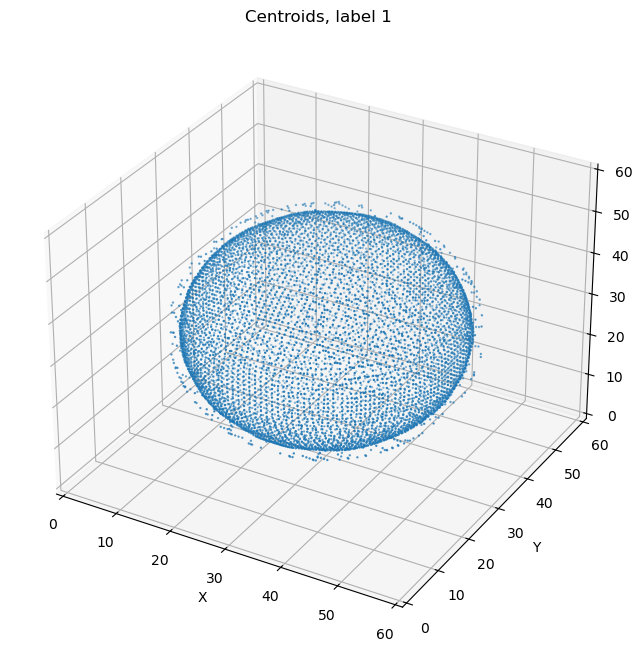

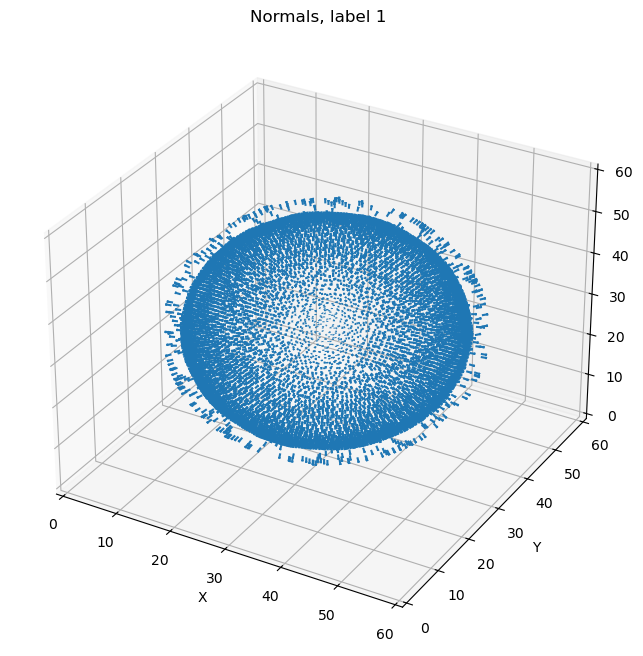

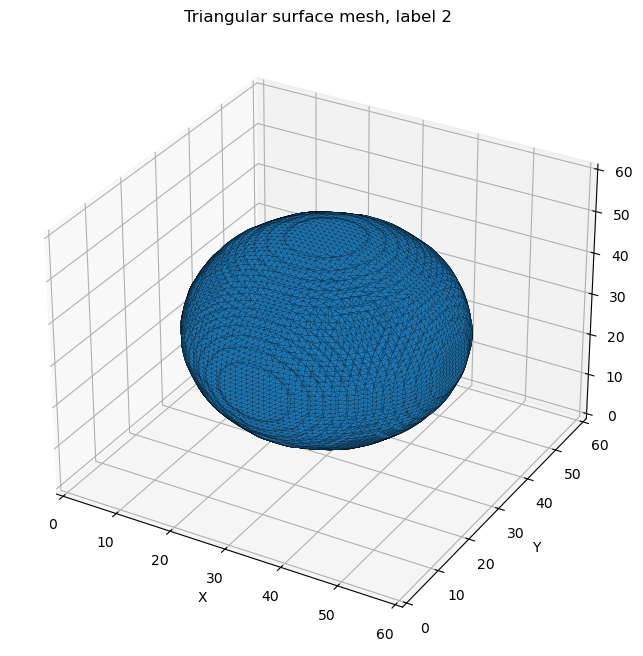

Excluded 7080/23392 triangles with area < 0.2


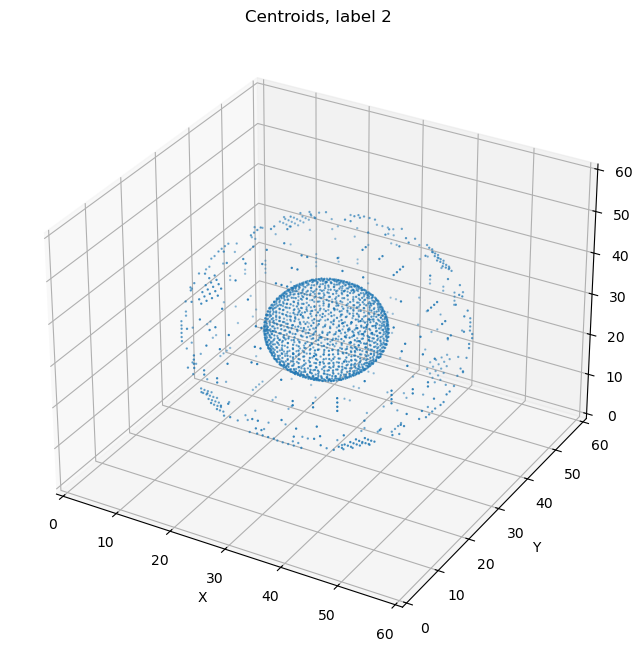

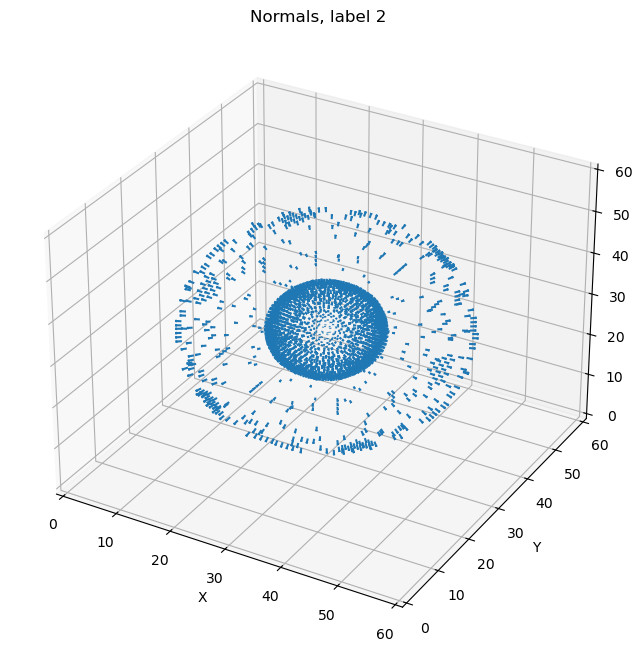

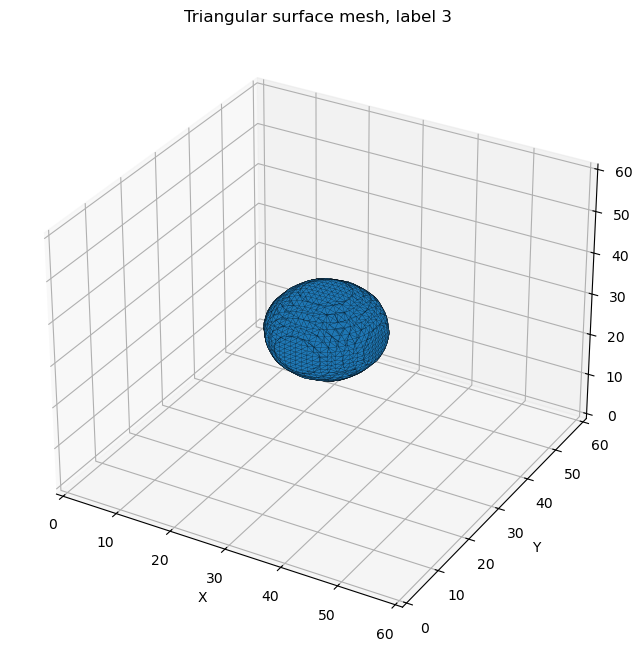

Excluded 1104/3608 triangles with area < 0.2


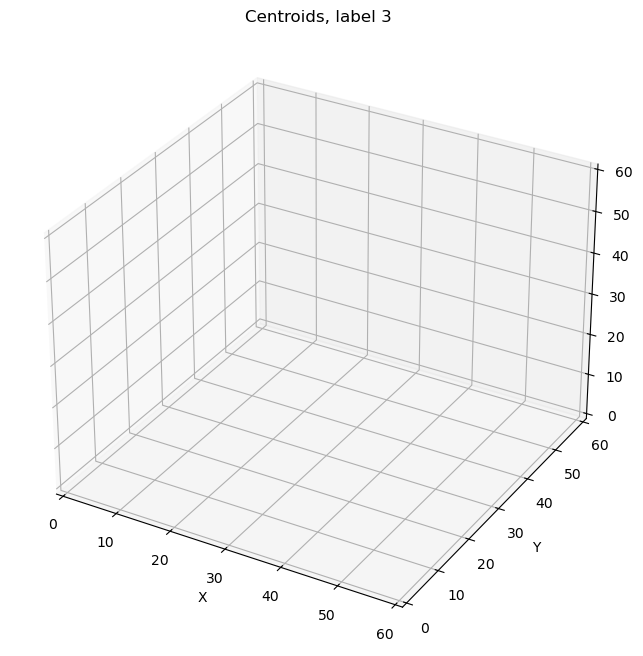

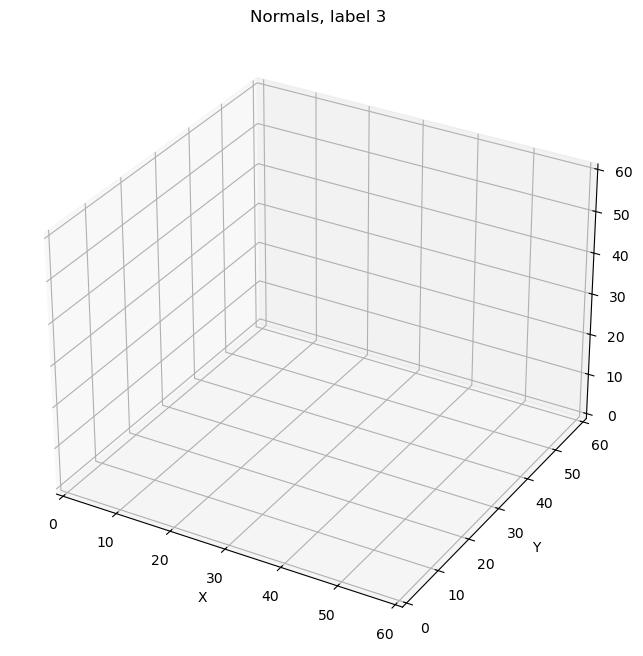

In [5]:
# original label for each voxel as flattened 1-d array
voxel_labels = np.ravel(mcxvol)
# lower label for each split voxel
lower_label = np.full(mcxvol.size, -1, dtype=np.int32)
# upper label for each split voxel
upper_label = np.zeros(mcxvol.size, dtype=np.int32)
# x,y,z components of normal vector for each voxel
avg_normals = np.zeros((3,mcxvol.size), dtype=np.float32)
# x,y,z, components of origin of normal vector for each voxel
avg_centroids = np.zeros((3,mcxvol.size), dtype=np.float32)

labels = np.sort(np.unique(mcxvol))
for label in labels:
    # binary mask for this label
    mask = np.zeros_like(mcxvol, dtype=np.float32)
    mask[mcxvol==label] = 1.0

    # apply gaussian smoothing
    mask = gaussian_filter(mask, sigma=1, radius=3, output=np.float32)

    # construct isosurface: a face has three indices into the vertices vector
    vertices, faces, _, _ = measure.marching_cubes(mask, level=0.5)
    # construct actual vertices for each triangle (3 [x,y,z] vertices per triangle)
    triangle_vertices = vertices[faces]
    plot_triangles(triangle_vertices, label, mcxvol.shape)

    # calculate area-weighted normal for each triangle = cross product of first two edges
    a = triangle_vertices[:, 0, :] - triangle_vertices[:, 1, :]
    b = triangle_vertices[:, 0, :] - triangle_vertices[:, 2, :]
    normals = -np.cross(a, b)

    # exclude triangles with areas significantly smaller than voxel face
    
    # NOTE: in the paper they "extract the largest single-connected surface component and ignore other disconnected triangles"
    # TODO: try to do this, compare output for some example volumes

    minimum_triangle_area = 0.2
    areas = np.linalg.norm(normals, axis=1)/2.0
    print(f"Excluded {np.sum(areas<minimum_triangle_area)}/{areas.size} triangles with area < {minimum_triangle_area}")
    non_zero_area_mask = areas >= minimum_triangle_area
    triangle_vertices = triangle_vertices[non_zero_area_mask]
    normals = normals[non_zero_area_mask]

    # calculate centroid for each triangle
    centroids = np.mean(triangle_vertices, axis=1)

    # get containing voxel for each centroid
    voxels = np.floor(centroids).astype(int)

    # convert 3-d voxel index to a flat 1-d index
    voxid = np.ravel_multi_index(voxels.T, mcxvol.shape)

    # get unique indices & counts
    uniqidx, uniqidx_counts = np.unique(voxid, return_counts=True)

    # assign label to upper part of these voxels
    upper_label[uniqidx] = label

    # identify the indices corresponding to voxels without an existing label
    uniqidx_unlabelled = uniqidx[lower_label[uniqidx]<0]
    voxid_unlabelled = np.isin(voxid, uniqidx_unlabelled)

    # assign label to lower part of these voxels if they don't already have a label
    lower_label[uniqidx_unlabelled] = label

    # sum area-weighted normals within each voxel
    for component in [0,1,2]:
        sum_norm_components = np.bincount(voxid, weights=normals[:,component], minlength=mcxvol.size)
        avg_normals[component,uniqidx_unlabelled] = sum_norm_components[uniqidx_unlabelled]
    # normalise normals
    avg_normals[:,uniqidx_unlabelled] /= np.linalg.norm(avg_normals.T, axis=1)[uniqidx_unlabelled]
    # average centroids within each voxel
    for component in [0,1,2]:
        sum_centroid_components = np.bincount(voxid, weights=centroids[:,component], minlength=mcxvol.size)
        sum_centroid_components[uniqidx] /= uniqidx_counts
        avg_centroids[component,uniqidx_unlabelled] += sum_centroid_components[uniqidx_unlabelled]

    plot_centroids(avg_centroids[:,uniqidx_unlabelled], label, mcxvol.shape)
    plot_normals(avg_normals[:,uniqidx_unlabelled], avg_centroids[:,uniqidx_unlabelled], label, mcxvol.shape)

In [6]:
# if lower_label = -1 then the voxel is not split by any surface -> use original voxel label
unsplit_voxels = lower_label<0
lower_label[unsplit_voxels] = voxel_labels[unsplit_voxels]

# subtract voxel index from centroid values to get centroid location within the voxel
voxel_indices = np.array(np.unravel_index(np.arange(mcxvol.size), mcxvol.shape))
avg_centroids[:,~unsplit_voxels] -= voxel_indices[:,~unsplit_voxels]

In [7]:
# resulting centroid values should all lie in range [0,1]
for component in [0,1,2]:
    assert np.all(avg_centroids[component]>=0.0)
    assert np.all(avg_centroids[component]<=1.0)

In [8]:
# convert all values to 8-bit unsigned integers
lower_label = lower_label.astype(np.uint8)
upper_label = upper_label.astype(np.uint8)
# centroids linearly scaled from [0,1] to [0,255]
avg_centroids = (avg_centroids*255.0).astype(np.uint8)
# normals linearly scaled from [-1,1] to [0,255]
avg_normals = ((0.5*avg_normals+0.5)*255.0).astype(np.uint8)

In [9]:
# todo: check order here: both of the 8 bytes, and of the voxels
data = np.stack((lower_label, upper_label, avg_centroids[0], avg_centroids[1], avg_centroids[2], avg_normals[0], avg_normals[1], avg_normals[2]), axis=1)

### TODO:

- make a plot of a single voxel with inclined plane and normal
- subtract voxels from centroid values & assert they are all in range (0,1)
- rescale centroids and normals to single byte 0-255 values
- try to re-generate the json input file & compare the data
- try to run mcx with generated input file
- tidy up, split into functions
- write some unit tests
- talk to kris
- implement in simpa
  - would involve large changes to volume generation logic
  - likely would have to be in addition to existing partial voxel implementation?

In [63]:
def plot_split_voxel(data_array, flat_voxel_index, shape):
    fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(20,8), subplot_kw={'projection':'3d', 'autoscale_on':'False'})

    # split voxel close-up
    voxel = np.unravel_index(flat_voxel_index, shape)
    data = data_array[flat_voxel_index]
    centroid = np.array([data[2], data[3], data[4]])/255.0
    normal = 2.0*np.array([data[5], data[6], data[7]])/255.0 - 1.0
    # construct plane from normal and centroid
    d = -centroid.dot(normal)
    # construct square mesh of 2d linearly spaced values
    points = np.meshgrid(np.linspace(0, 1, 50),np.linspace(0,1,50))
    # select largest normal component (x,y,z) to use as denominator for numerical stability
    denom = np.argmax(np.abs(normal))
    # calculate values of component `denom` at each point in 2d mesh
    vals = (-normal[(denom+1)%3] * points[0] - normal[(denom+2)%3] * points[1] - d) / normal[denom]
    # exclude any values that lie outside the voxel
    vals[(vals<0)|(vals>1)] = np.nan
    points.append(vals)
    # plot x, y, z values
    ax.plot_surface(points[2-denom], points[(3-denom)%3], points[(4-denom)%3], alpha=0.5);
    ax.scatter(centroid[0], centroid[1], centroid[2])
    ax.quiver(centroid[0], centroid[1], centroid[2], normal[0], normal[1], normal[2], length=0.25, normalize=True)
    ax.set_title(f"Split voxel at {voxel}: label {data[0]} --> label {data[1]}")
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_zlim(0,1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    # voxel location in volume
    ax2.scatter(voxel[0], voxel[1], voxel[2], s=50, color='red')
    voxels = np.unravel_index(np.where(data_array[:,1]==data[1])[0], shape)
    ax2.scatter(voxels[0], voxels[1], voxels[2], s=1, color='blue', alpha=0.2)
    ax2.set_title(f"Voxel {voxel} location")
    ax2.set_xlim(0,shape[0])
    ax2.set_ylim(0,shape[1])
    ax2.set_zlim(0,shape[2])
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

    plt.show()

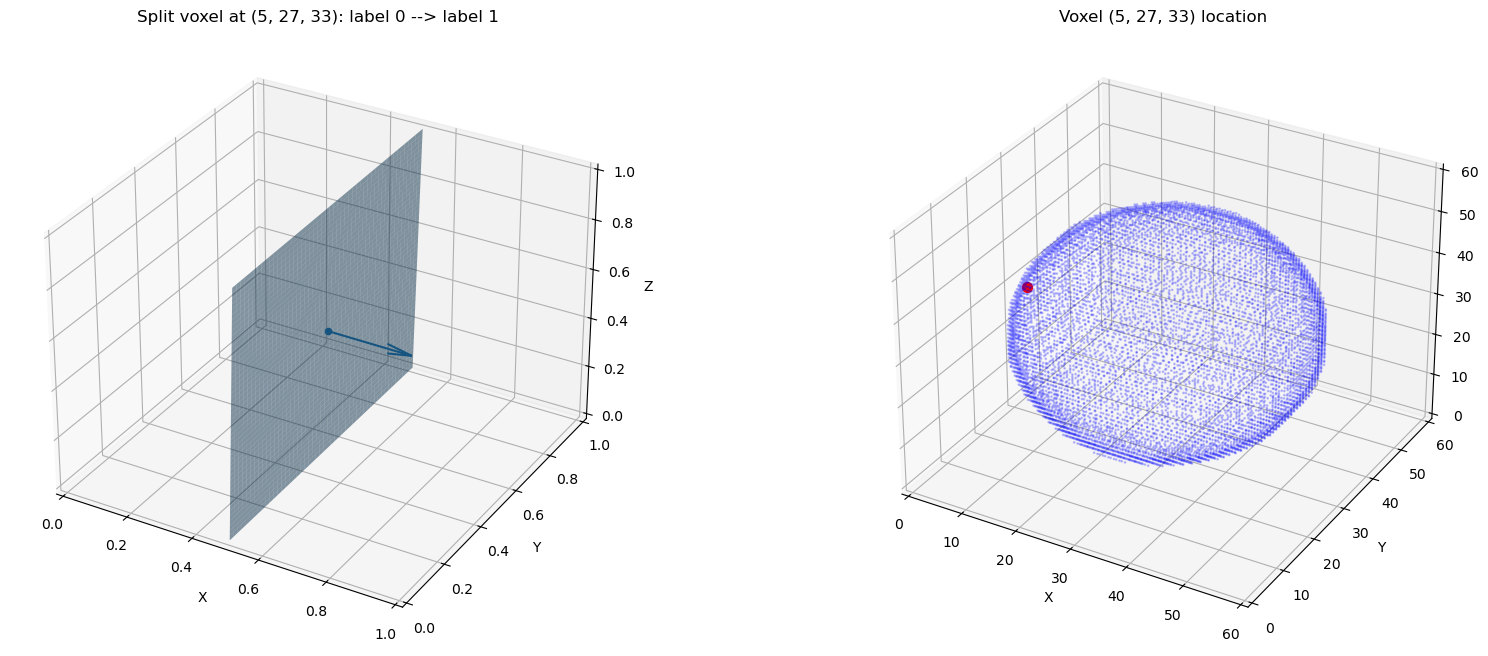

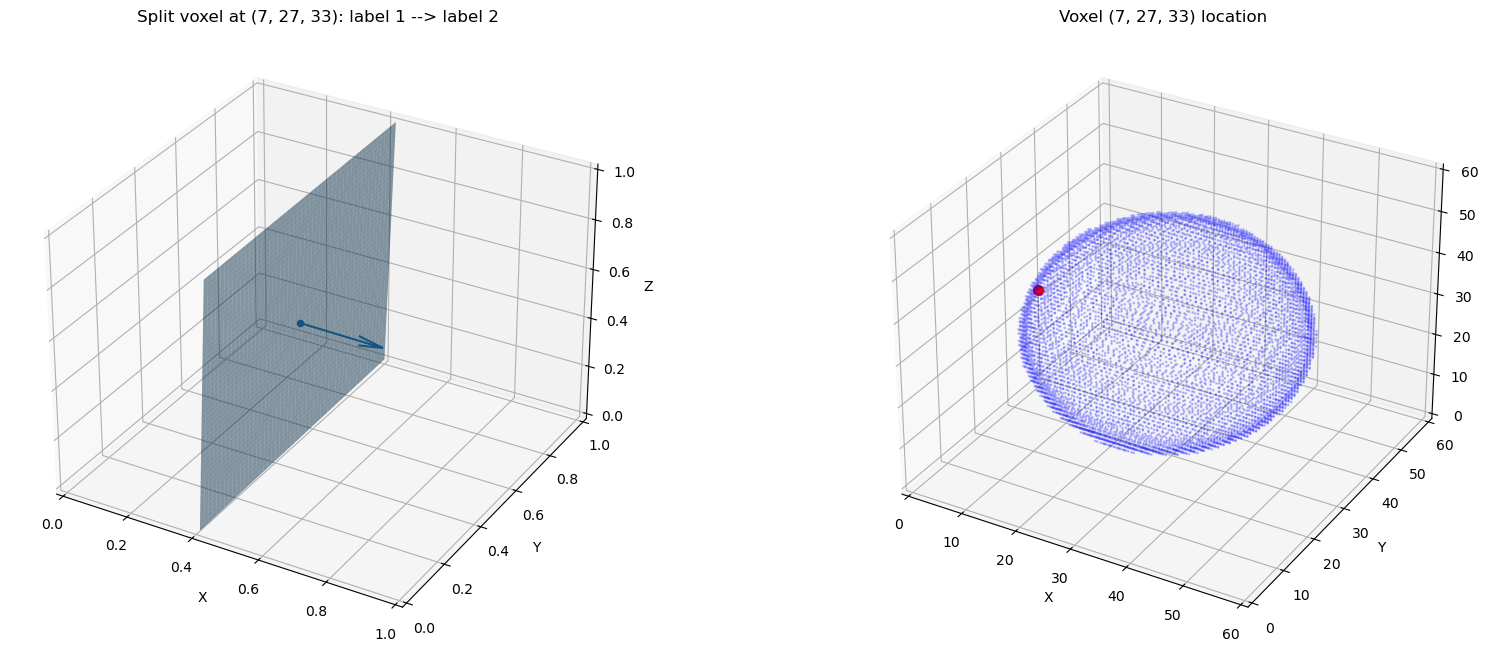

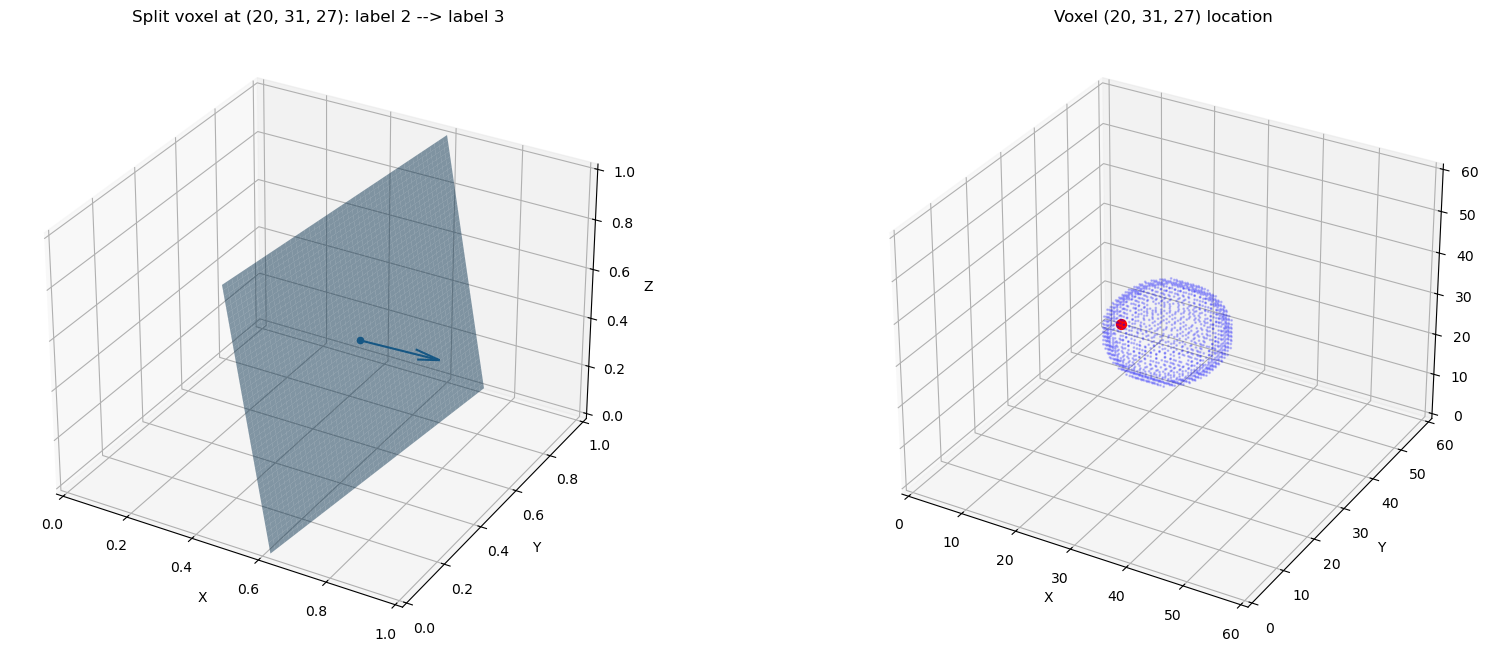

In [64]:
for i in [19653, 26853, 73887]:
    plot_split_voxel(data, i, mcxvol.shape)

In [75]:
def plot_split_voxels(data_array, shape, lower_label, upper_label):
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111, projection='3d', autoscale_on=False)
    ax.set_title(f"Split voxels label {lower_label} --> label {upper_label}")
    idxs = np.where((data_array[:,0]==lower_label) & (data_array[:,1]==upper_label))[0]
    for idx in idxs:
        data = data_array[idx]
        voxel = np.unravel_index(idx, shape)
        centroid = np.array([data[2], data[3], data[4]])/255.0
        normal = 2.0*np.array([data[5], data[6], data[7]])/255.0 - 1.0
        # construct plane from normal and centroid
        d = -centroid.dot(normal)
        # select largest normal component (x,y,z) to use as denominator dimension for numerical stability
        denom = np.argmax(np.abs(normal))
        # construct square mesh of 2d linearly spaced values in the other two dimensions
        points = np.meshgrid(np.linspace(0,1,50),np.linspace(0,1,50))
        # calculate values of component `denom` at each point in 2d mesh
        vals = (-normal[(denom+1)%3] * points[0] - normal[(denom+2)%3] * points[1] - d) / normal[denom]
        # exclude any values that lie outside the voxel
        vals[(vals<0)|(vals>1)] = np.nan
        points.append(vals)
        # plot x, y, z values
        ax.plot_surface(points[2-denom]+voxel[0], points[(3-denom)%3]+voxel[1], points[(4-denom)%3]+voxel[2], alpha=0.5)
        ax.quiver(centroid[0]+voxel[0], centroid[1]+voxel[1], centroid[2]+voxel[2], normal[0], normal[1], normal[2], length=0.25)
    voxels = np.array(np.unravel_index(idxs, shape))
    ax.set_xlim(np.min(voxels[0,:])-1, np.max(voxels[0,:])+1)
    ax.set_ylim(np.min(voxels[1,:])-1, np.max(voxels[1,:])+1)
    ax.set_zlim(np.min(voxels[2,:])-1, np.max(voxels[2,:])+1)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    plt.show()

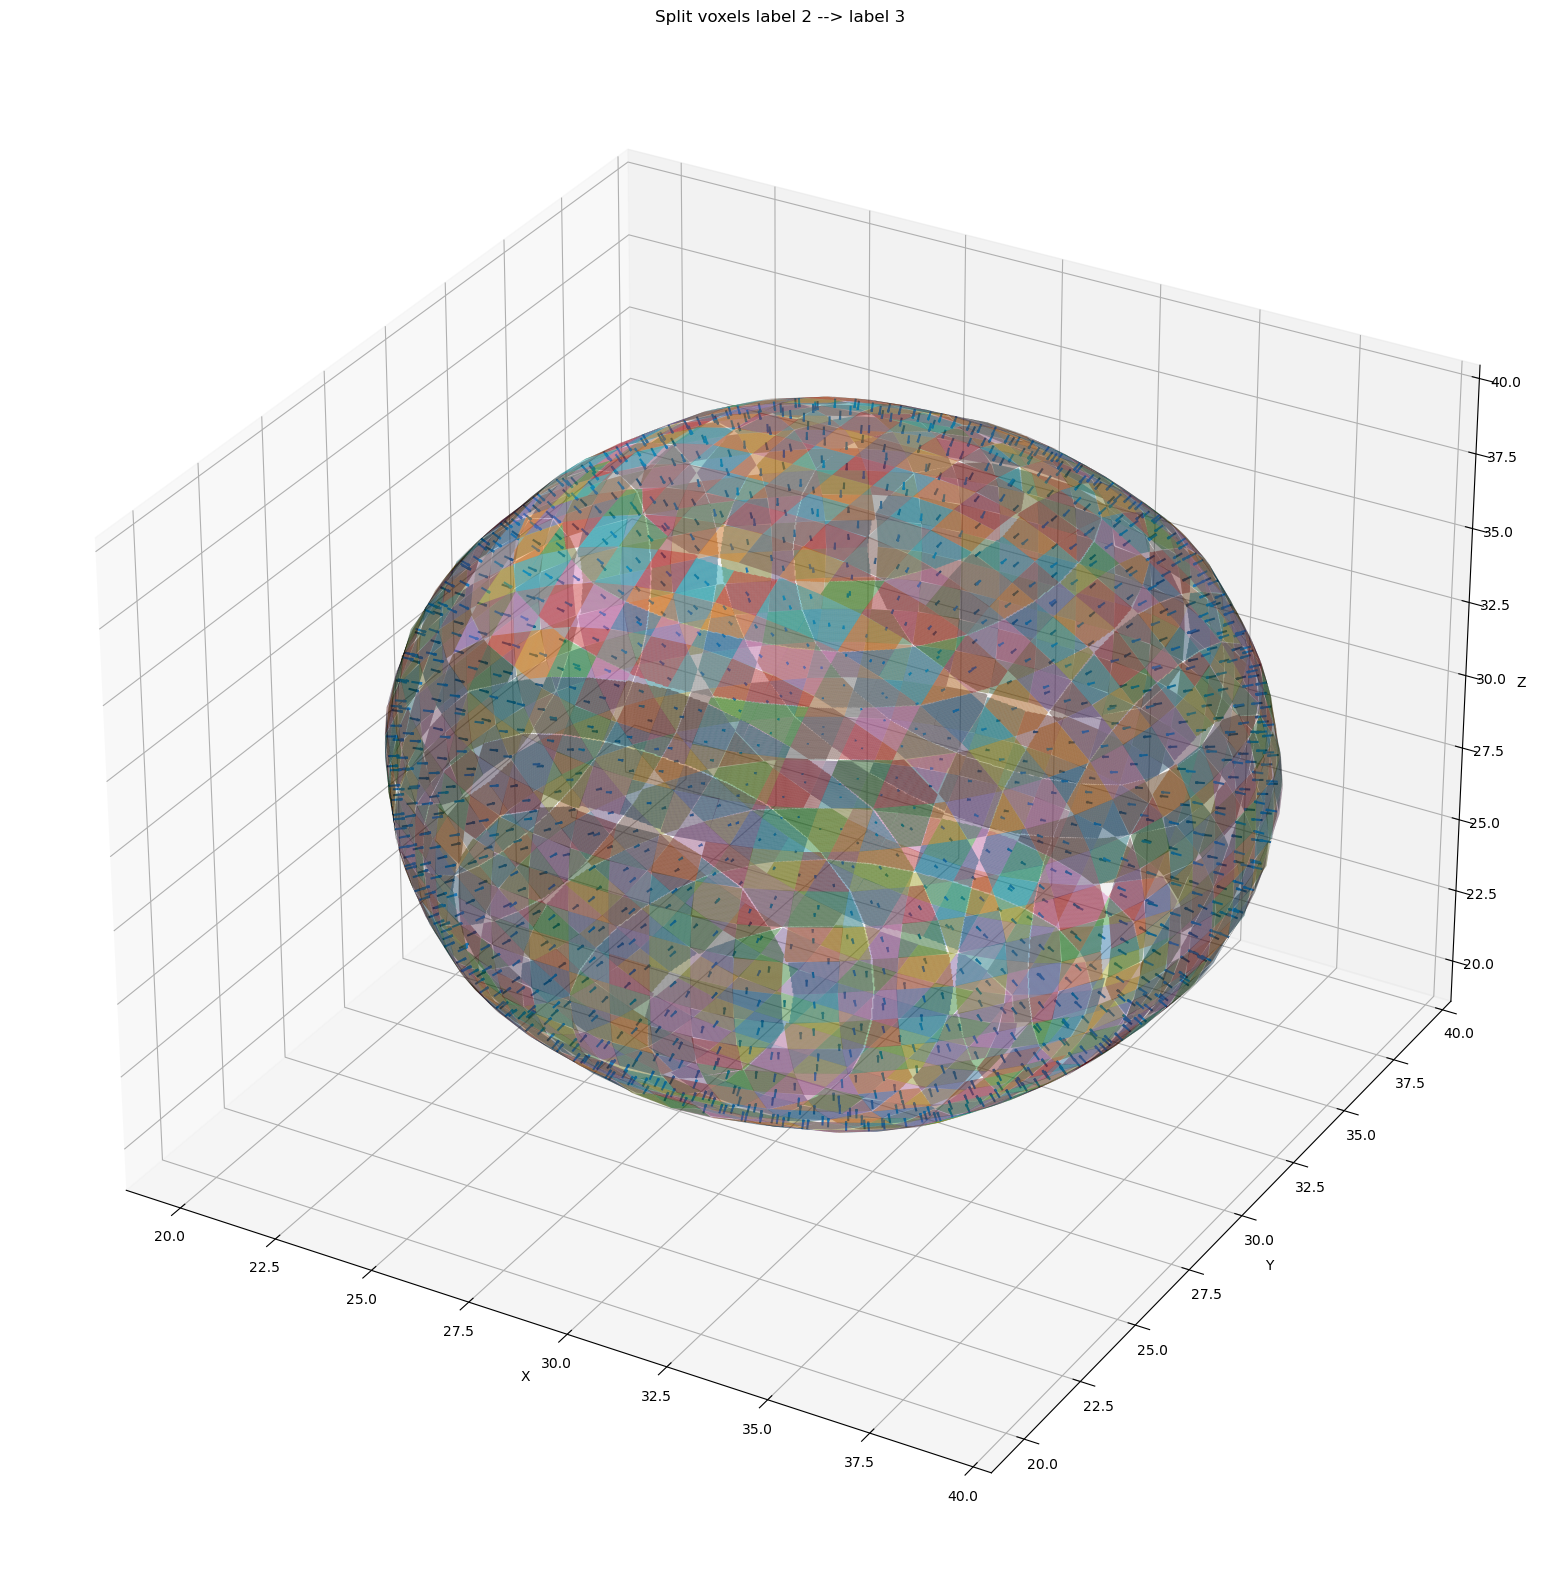

In [76]:
plot_split_voxels(data, mcxvol.shape, 2, 3)

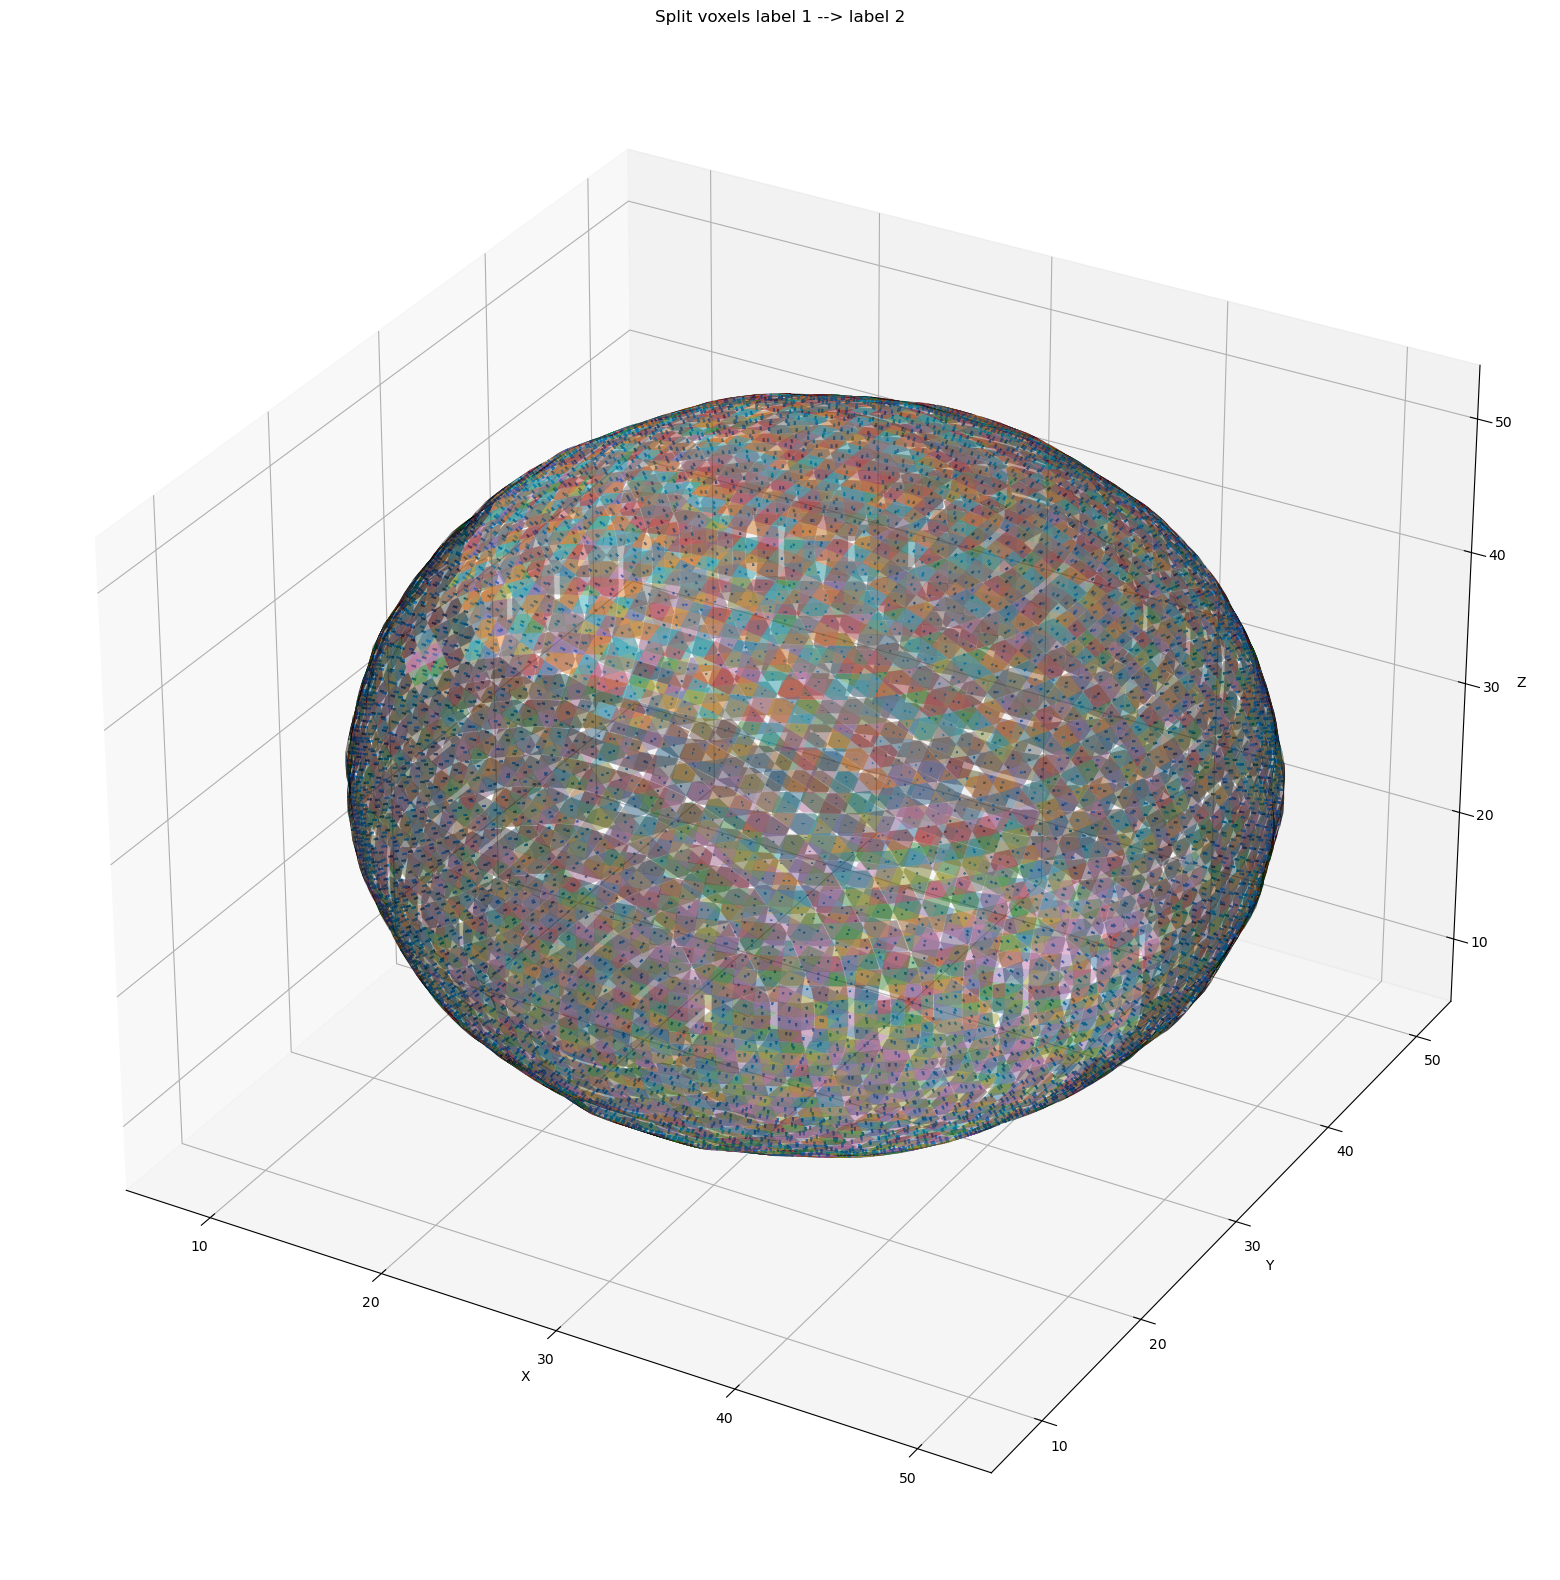

In [77]:
plot_split_voxels(data, mcxvol.shape, 1, 2)

ValueError: zero-size array to reduction operation minimum which has no identity

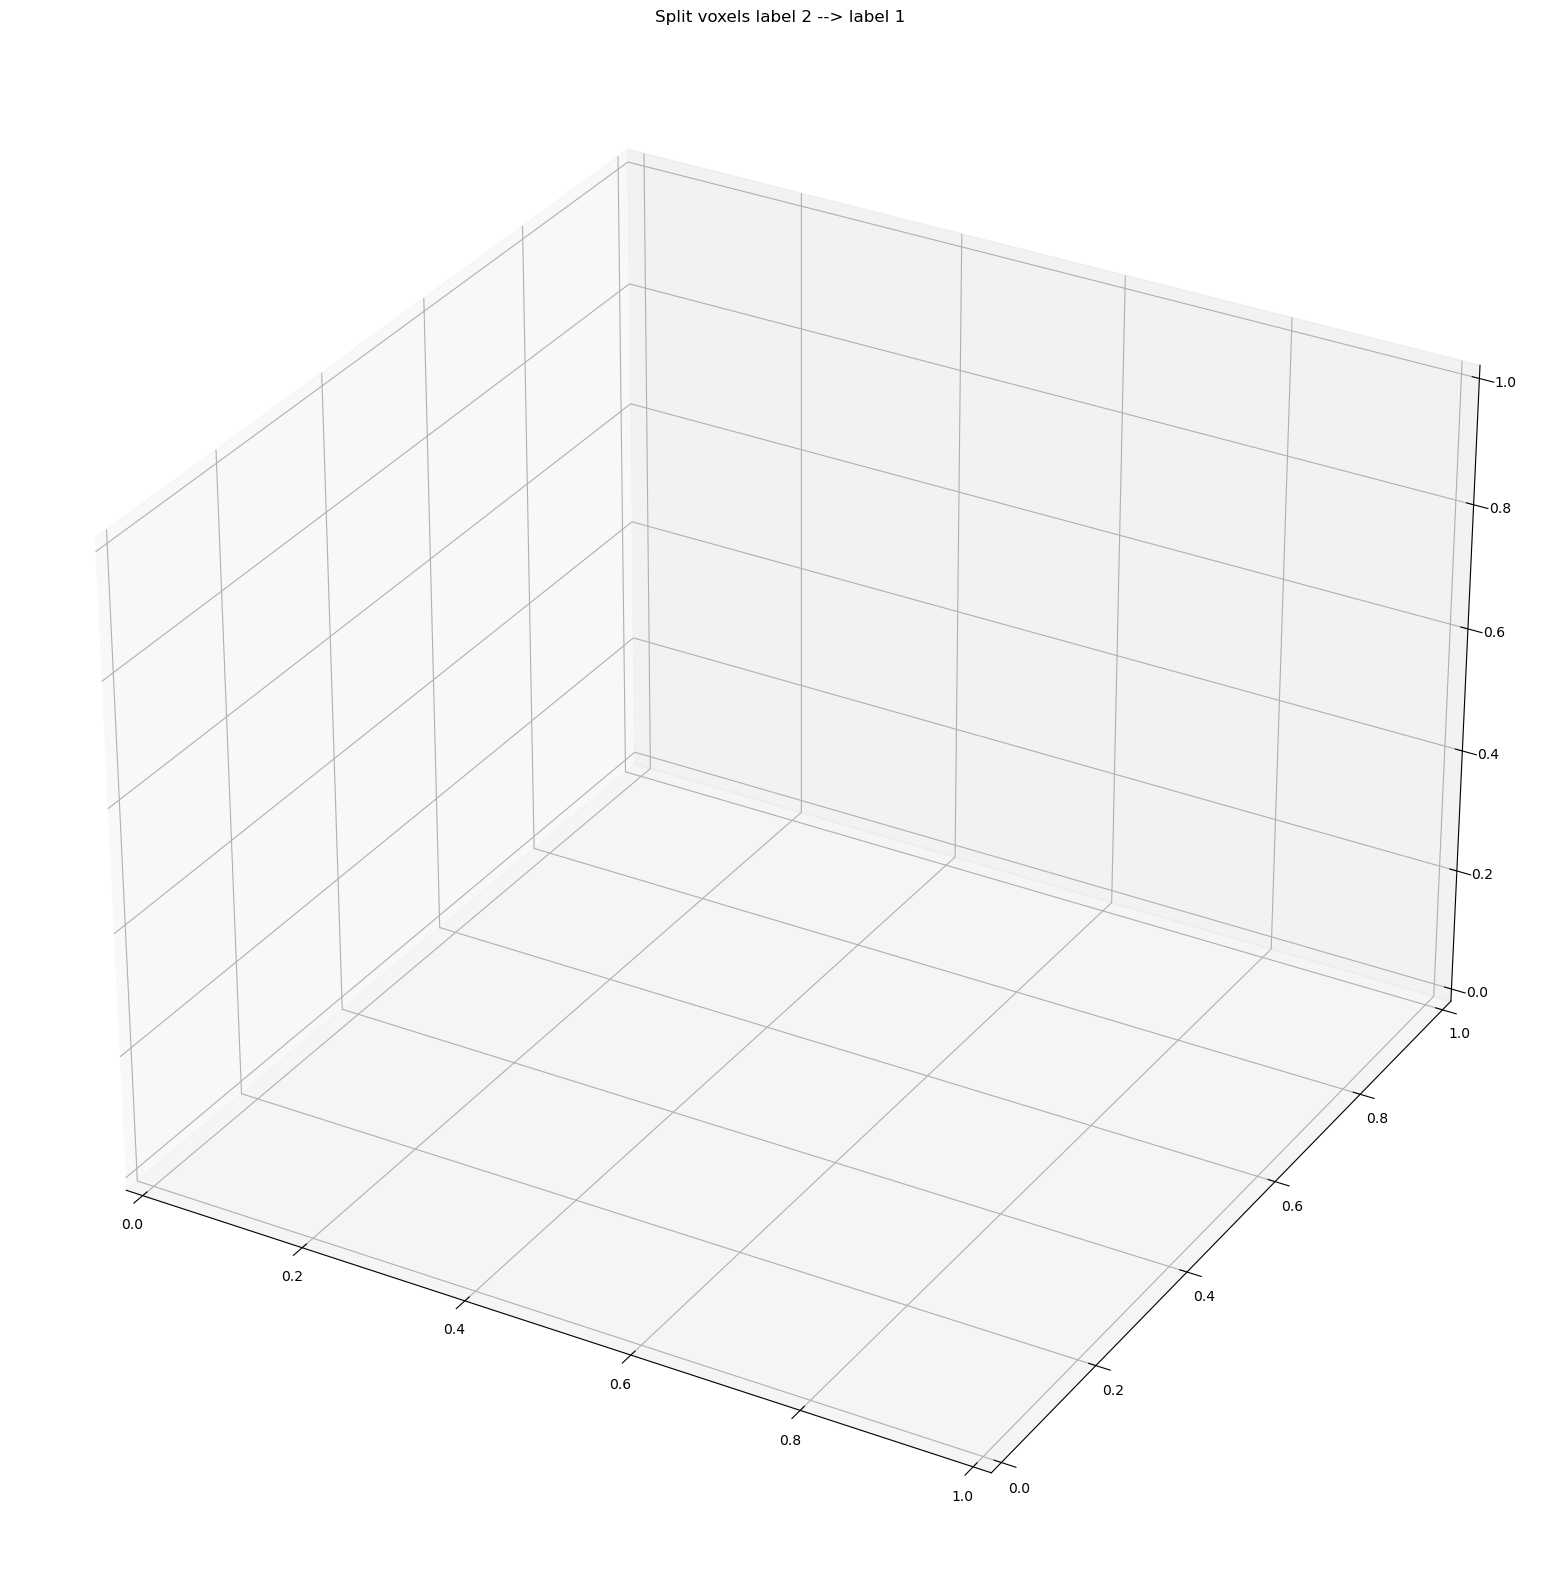

In [78]:
plot_split_voxels(data, mcxvol.shape, 2, 1)